# Установка и импорт библиотек

In [ ]:
!pip install openpyxl
!pip install catboost
!pip install optuna
!pip install scikit-learn
!pip install seaborn

In [71]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import optuna
from optuna.samplers import TPESampler
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
# Загрузка файла
# Чтение данных
df = pd.read_csv('data/external.csv')

# Проверка
print(df.head())

   Unnamed: 0  day  month  year  Temperature  RH  Ws  Rain  FFMC  DMC    DC  \
0           0    1      6  2012           29  57  18   0.0  65.7  3.4   7.6   
1           1    2      6  2012           29  61  13   1.3  64.4  4.1   7.6   
2           2    3      6  2012           26  82  22  13.1  47.1  2.5   7.1   
3           3    4      6  2012           25  89  13   2.5  28.6  1.3   6.9   
4           4    5      6  2012           27  77  16   0.0  64.8  3.0  14.2   

   ISI  BUI  FWI   Classes  Region  
0  1.3  3.4  0.5  not fire       1  
1  1.0  3.9  0.4  not fire       1  
2  0.3  2.7  0.1  not fire       1  
3  0.0  1.7  0.0  not fire       1  
4  1.2  3.9  0.5  not fire       1  


In [75]:
# Подготовка данных
df = pd.read_csv('data/external.csv')

# Удаляем незначимые признаки.
# df.drop(["Unnamed: 0", "day", "year", "Region"], axis=1, inplace=True) // день, год не несут полезной нагрузки, а с month в датасете немного хуже начинает предсказывать + хочется по изменению погодных условий по отношению к нормальным предсказывать, а месяц будет создавать проблемы в регионах с другим климатом.
df.drop(["Unnamed: 0", "day", "year", "month", "Region"], axis=1, inplace=True)

# Конвертируем значения таргетной колонки в числовые признаки
df["Classes"] = df["Classes"].map({"not fire": 0, "fire": 1})

# Разделение на тренировочную и тестовую выборки
X = df.drop('Classes', axis=1)
y = df["Classes"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


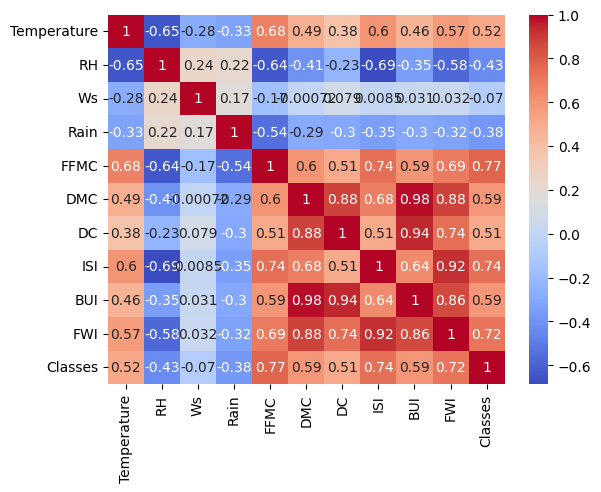

In [76]:
# корреляции

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [66]:
# Создание Pool для CatBoost
train_pool = Pool(
    X_train,
    y_train,
)

test_pool = Pool(
    X_test,
    y_test,
)

# Функция для оптимизации гиперпараметров с Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 6, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'auto_class_weights': 'Balanced',
        'verbose': False,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'early_stopping_rounds': 50,
    }

    scores = []
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for train_idx, valid_idx in cv.split(X_train, y_train):
        x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = CatBoostClassifier(**params)
        model.fit(
            x_tr, y_tr,
            eval_set=(x_val, y_val),
            use_best_model=True,
            verbose=0
        )

        preds = model.predict(x_val)
        scores.append(f1_score(y_val, preds))

    return np.mean(scores)

# Отключаем лишние логи Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Оптимизация гиперпараметров
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
)
study.optimize(objective, n_trials=30, show_progress_bar=True)

Best trial: 20. Best value: 0.995434: 100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


In [67]:
# Обучение модели с лучшими параметрами и оценка

# Создание Pool для CatBoost
final_train_pool = Pool(
    X_train,
    y_train,
)
final_test_pool = Pool(
    X_test,
    y_test,
)


best_params = study.best_params
best_model = CatBoostClassifier(**best_params, verbose=False)
best_model.fit(
    final_train_pool,
    eval_set=final_test_pool,
    verbose=0
)

# Прогноз и оценка
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])}")

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.97      1.00      0.98        28

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49

ROC-AUC: 1.0


In [68]:
# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
       feature  importance
4         FFMC   56.352333
7          ISI    9.075373
1           RH    8.098379
2           Ws    6.958483
9          FWI    5.690948
5          DMC    4.023889
0  Temperature    3.565110
6           DC    2.935690
8          BUI    2.314662
3         Rain    0.985133


Значение Roc Auc - 1. Модель идеально разделяет классы.

Выводы
1. Оба класса предсказываются отлично.
2. Модель работает хорошо (accuracy = 98%). Сказывается, что датасет вылизан и отбалансирован.
3. Для класса 0 и 1 высокие precision и recall, что тоже хорошо.
4. Ожидаемо, [FFMC](https://github.com/NCAR/fire-indices/blob/master/calc_ffmc.ncl) индекс самое значимое влияние имеет. По сути, он измеряет, насколько легко может загореться растительный материал. Соответственно чем он выше, тем в совокупности и вероятность пожара будет выше.

Пока все похоже на правду, несмотря на то, что датасет небольшой.

In [40]:
# Сохранение модели
best_model.save_model("models/external.cbm")